In [1]:
import pandas as pd
import numpy as np
import gower
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats.contingency import crosstab

import load.load_dataset as ds

from umap import UMAP
from sklearn.cluster import HDBSCAN

import seaborn as sns
import matplotlib.pyplot as plt

import os
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
param_dict = joblib.load(os.path.join(os.getcwd(), "parameters.joblib"))

In [3]:
dataset_name = "bank"

agg = "ensemble"
neigh = "medoid"

model_list = ['model1', 'model2', 'model3']
methods_labels = ["IG", "DL", "LRP", agg]
folder = os.path.join(os.getcwd(), f"results_{neigh}")

In [4]:
dataset = ds.Dataset(dataset_name)

feature_names, categorical_features, categorical_names, ordinal,discrete, encoder, num_features = dataset.info()
X_train_or, X_train, y_train = dataset.train()
X_val_or, X_val, y_val = dataset.validation()
X_test_or, X_test, y_test = dataset.test()

print(X_train_or.shape, X_val_or.shape, X_test_or.shape)

(36168, 14) (8043, 14) (1000, 14)


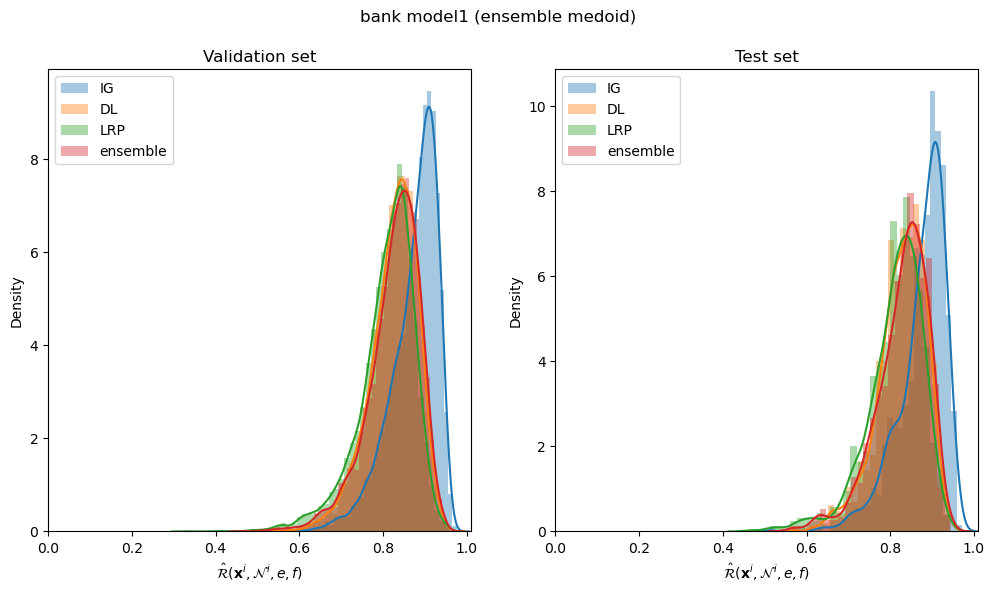

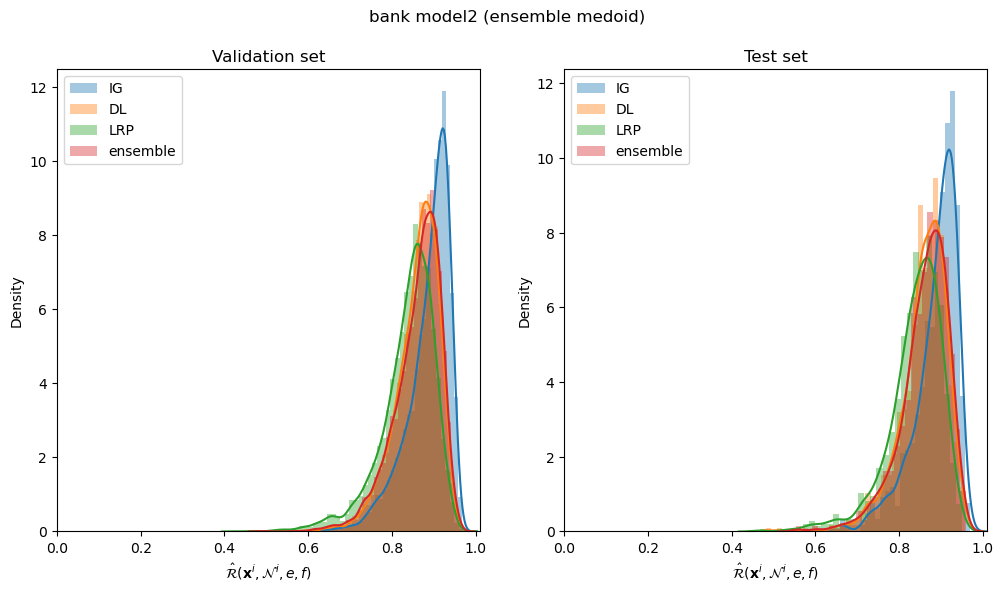

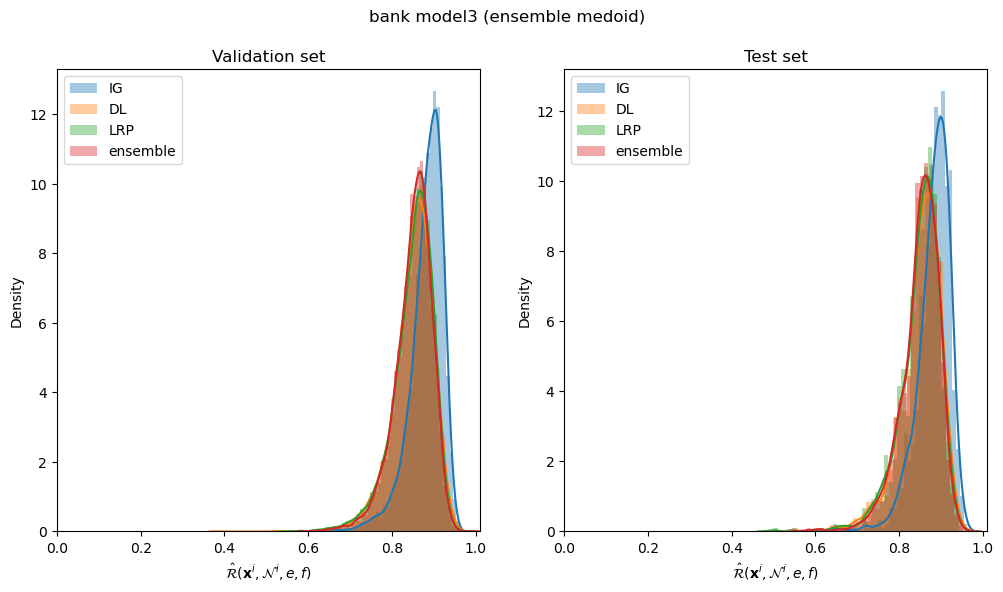

In [6]:
for model_name in model_list:
    folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")

    rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))
    rho_test = np.load(os.path.join(folder_, "test", f"robustness_{agg}_{neigh}.npy"))

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    for i in range(len(methods_labels)):
        sns.distplot(rho_valid[:,i], ax = ax[0], label=methods_labels[i])
        sns.distplot(rho_test[:,i], ax= ax[1], label=methods_labels[i])

    ax[0].set_title("Validation set")
    ax[1].set_title("Test set")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlim(0, 1.01)
    ax[1].set_xlim(0,1.01)
    ax[0].set_xlabel("$\hat{\mathcal{R}}(\mathbf{x}^i, \mathcal{N}^{i}, e, f)$")
    ax[1].set_xlabel("$\hat{\mathcal{R}}(\mathbf{x}^i, \mathcal{N}^{i}, e, f)$")
    plt.suptitle(f"{dataset_name} {model_name} ({agg} {neigh})")
    plt.show()

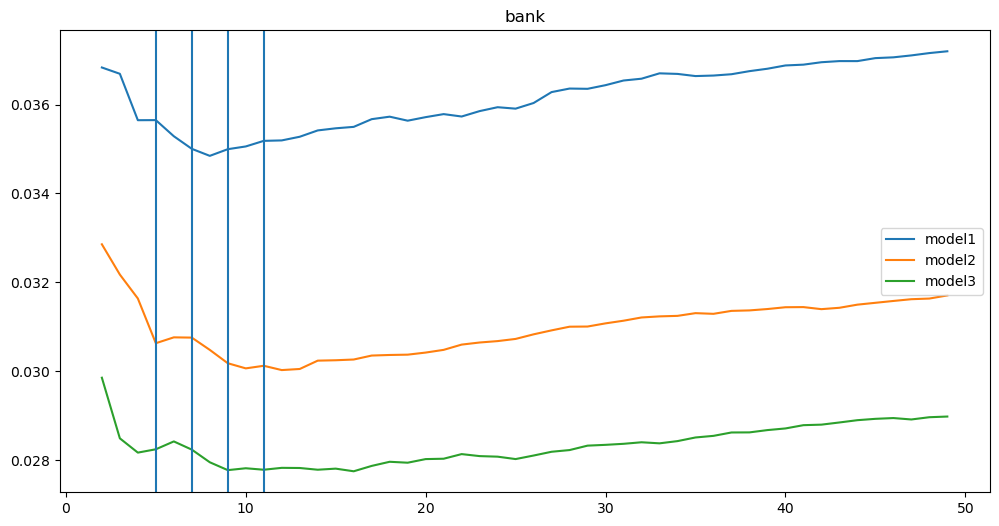

In [7]:
plt.figure(figsize=(12,6))
for model_name in model_list:
    folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")

    rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))
    rho_test = np.load(os.path.join(folder_, "test", f"robustness_{agg}_{neigh}.npy"))

    rho_valid = np.nan_to_num(rho_valid)

    tmp = []
    for k in range(2,50):
        regr = KNeighborsRegressor(n_neighbors=k).fit(X_val_or, rho_valid[:,3])
        rob_ = regr.predict(X_test_or)

        tmp.append(np.mean(np.abs(rho_test[:,3]-rob_)))
    
    plt.plot(range(2,50), tmp, label = model_name)

plt.axvline(x=5)
plt.axvline(x=7)
plt.axvline(x=9)
plt.axvline(x=11)
plt.title(dataset_name)
plt.legend()
plt.show()

In [10]:
k_r = 7
# param_dict[dataset_name][f"{agg}_{neigh}_k"] = k_r

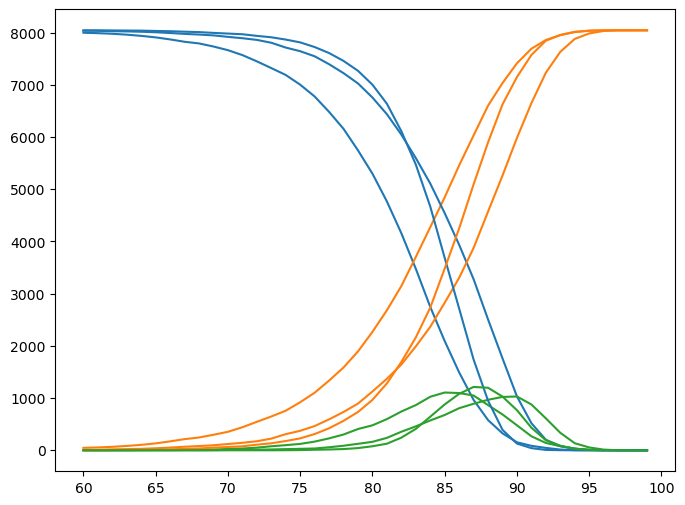

In [11]:
plt.figure(figsize=(8,6))
for model_name in model_list:
    folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")

    rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))
    rho_valid = np.nan_to_num(rho_valid)
    rob_= rho_valid[:,3]
                

    regr = KNeighborsRegressor(n_neighbors=k_r).fit(X_val_or, rob_)
    rob_hat= regr.predict(X_val_or)

    non_robust = []
    robust = []
    other_=[]

    for th in range(60, 100):
        th = th/100
        
        robust.append(len(set.intersection(*map(set, [np.where(rob_ >= th)[0], np.where(rob_hat >= th)[0]]))))
        other_.append(len(set.intersection(*map(set, [np.where(rob_ >= th)[0], np.where(rob_hat < th)[0]]))))
        non_robust.append(len(np.where(rob_<th)[0]))

    plt.plot(range(60, 100), robust,  c = 'tab:blue')
    plt.plot(range(60, 100), non_robust,  c = 'tab:orange')
    plt.plot(range(60, 100), other_,  c ='tab:green')
plt.show()

In [12]:
th = 0.80
#param_dict[dataset_name][f"{agg}_{neigh}_th"] = th

#joblib.dump(param_dict, os.path.join(os.getcwd(), "parameters.joblib"))

In [13]:
model_name = model_list[0]

folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")
rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))
rho_test = np.load(os.path.join(folder_, "test", f"robustness_{agg}_{neigh}.npy"))

rho_valid = np.nan_to_num(rho_valid)
regr = KNeighborsRegressor(n_neighbors=k_r).fit(X_val_or, rho_valid[:,3])
rob_hat = regr.predict(X_test_or)
rob_= rho_test[:,3]

list_regressor = rob_hat >= th
list_real = rob_ >= th

overall = np.array(list_regressor).astype(int) + np.array(list_real).astype(int)
total = len(overall)
robust = len(np.where(overall==2)[0])
non_robust = len(np.where(list_real == 0)[0])
maybe = total - robust - non_robust

print("Robust", robust, "\nMaybe", maybe, "\nNon Robust", non_robust,"\nTotal", total)

Robust 652 
Maybe 71 
Non Robust 277 
Total 1000


In [ ]:
joblib.dump(param_dict, os.path.join(os.getcwd(), "parameters.joblib"))

In [14]:
umap = UMAP(n_components=2)
X_new = umap.fit_transform(X_val_or)

hdbscan = HDBSCAN(min_cluster_size=100)
hdbscan.fit(X_new)
hdbs_labels = hdbscan.labels_
print(np.unique(hdbs_labels))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25]


In [15]:
folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")
rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))

cols = []
for cl_idx in np.unique(hdbs_labels):
    rho_tmp = rho_valid[hdbs_labels==cl_idx]
    cols.append(np.round(np.mean(rho_tmp), 2))

cols = np.array(cols)
colors = cols[hdbs_labels]

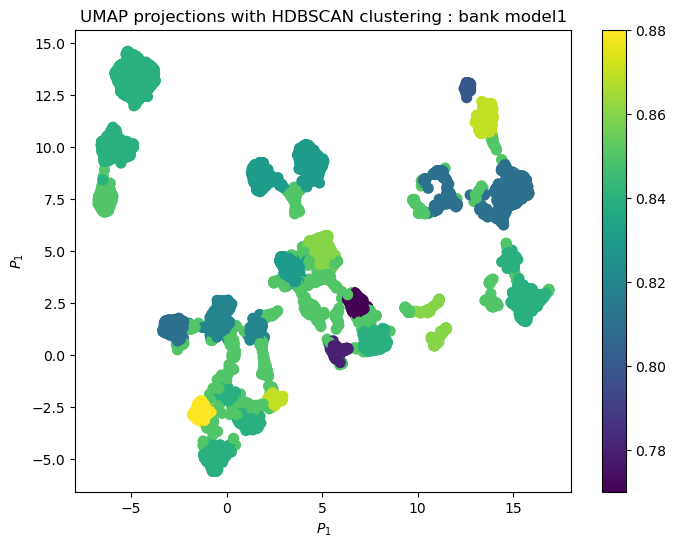

In [16]:
plt.figure(figsize=(8,6))

plt.scatter(X_new[:,0], X_new[:,1], c=colors, s=50)
plt.title(f"UMAP projections with HDBSCAN clustering : {dataset_name} {model_name}")
plt.xlabel("$P_1$")
plt.ylabel("$P_1$")
plt.colorbar()
plt.show()

In [ ]:
for neigh in ["medoid", "random"]:
    folder = os.path.join(os.getcwd(), f"results_{neigh}")
    for agg in  ["ensemble", "mean"]:
        final = []
        for dataset_name in param_dict.keys():

            dataset = ds.Dataset(dataset_name)
            X_val_or, X_val, y_val = dataset.validation()
            X_test_or, X_test, y_test = dataset.test()

            dim = X_test_or.shape[0]
            k_r = param_dict[dataset_name][f"{agg}_{neigh}_k"]

            gt = np.argmax(y_test.detach().numpy(), axis=1)
            model_pred = []
            for model_name in model_list:
                model = dataset.load_model(model_name)
                model_pred.append(np.argmax(model(X_test).detach().numpy(), axis=1))

            model_pred=np.array(model_pred)

            pred_all = np.sum(model_pred, axis=0)
            concordant = np.where(pred_all%3==0)[0]
            discordant = np.where(pred_all%3!=0)[0]

            models3 = np.ones(dim)
            models3[discordant] = 0

            for model_name in model_list:
                folder_ = os.path.join(folder, f"{dataset_name}_{model_name}")

                rho_valid = np.load(os.path.join(folder_, "validation", f"robustness_{agg}_{neigh}.npy"))
                rho_test = np.load(os.path.join(folder_, "test", f"robustness_{agg}_{neigh}.npy"))

                rho_valid = np.nan_to_num(rho_valid)

                regr = KNeighborsRegressor(n_neighbors=k_r).fit(X_val_or, rho_valid[:,3])
                rob_hat = regr.predict(X_test_or)
                rob_= rho_test[:,3]

                for th in np.arange(0,1, 0.01):
                    list_regressor = rob_hat >= th
                    list_real = rob_ >= th

                    overall = np.array(list_regressor).astype(int) + np.array(list_real).astype(int)
                    ROBUST = np.where(overall==2)[0]
                    NONROBUST = np.where(list_real == 0)[0]

                    total = len(overall)
                    robust = len(ROBUST)
                    non_robust = len(NONROBUST)
                    maybe = total - robust - non_robust

                    th_ = rob_ >= th

                    contingency = crosstab(models3, th_, levels=([1,0], [True, False]))

                    robust_cross = contingency.count[:,0]
                    non_robust_cross = contingency.count[:,1]

                    final.append([dataset_name, model_name, th, robust, maybe, non_robust, total, robust_cross[0], robust_cross[1],  np.sum(th_), non_robust_cross[0], non_robust_cross[1], dim-np.sum(th_)])

        df = pd.DataFrame(final)
        df.columns = ["dataset", "model", "threshold", "robust", "maybe", "non robust", "len", "robust concordant", "robust discordant",  "tot robust", "non robust concordant", "non robust discordant",  "tot non robust"]
        df.to_excel(os.path.join(os.getcwd(), "results_roc_auc", f"{agg}_{neigh}_threshold.xlsx"), index=False)


In [109]:
df_ens = pd.read_excel(os.path.join(os.getcwd(), "results_roc_auc", "ensemble_medoid_threshold.xlsx"))
df_mean = pd.read_excel(os.path.join(os.getcwd(), "results_roc_auc","mean_medoid_threshold.xlsx"))
df_ens_random = pd.read_excel(os.path.join(os.getcwd(), "results_roc_auc", "ensemble_random_threshold.xlsx"))
df_mean_random = pd.read_excel(os.path.join(os.getcwd(), "results_roc_auc", "mean_random_threshold.xlsx"))

In [110]:
df_ens

,dataset,model,threshold,robust,maybe,non robust,len,robust concordant,robust discordant,tot robust,non robust concordant,non robust discordant,tot non robust
0,adult,model1,0.00,1000,0,0,1000,899,101,1000,0,0,0
1,adult,model1,0.01,1000,0,0,1000,899,101,1000,0,0,0
2,adult,model1,0.02,1000,0,0,1000,899,101,1000,0,0,0
3,adult,model1,0.03,1000,0,0,1000,899,101,1000,0,0,0
4,adult,model1,0.04,1000,0,0,1000,899,101,1000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,wine,model3,0.95,0,6,194,200,4,2,6,182,12,194
2396,wine,model3,0.96,0,3,197,200,2,1,3,184,13,197
2397,wine,model3,0.97,0,1,199,200,1,0,1,185,14,199
2398,wine,model3,0.98,0,1,199,200,1,0,1,185,14,199


In [ ]:
for df in [df_ens, df_mean, df_ens_random, df_mean_random]:
           
    df["true positive"] = df["robust concordant"]
    df["false positive"] = df["robust discordant"] 

    df["false negative"] = df["non robust concordant"]
    df["true negative"] = df["non robust discordant"] 

    df["positive"] = df["true positive"]+df["false negative"]
    df["negative"] = df["true negative"]+df["false positive"]

    df["TPR"] = df["true positive"]/df["positive"]
    df["FPR"] = df["false positive"]/df["negative"]


    df['acc'] = (df['true positive'] + df['true negative'])/df["len"]

    df = df.fillna(0, inplace=True)

In [113]:
model_colors = {"model1": "tab:blue", "model2": "tab:orange", "model3": "tab:green"}

In [114]:
df_ens

,dataset,model,threshold,robust,maybe,non robust,len,robust concordant,robust discordant,tot robust,...,tot non robust,true positive,false positive,false negative,true negative,positive,negative,TPR,FPR,acc
0,adult,model1,0.00,1000,0,0,1000,899,101,1000,...,0,899,101,0,0,899,101,1.000000,1.000000,0.899
1,adult,model1,0.01,1000,0,0,1000,899,101,1000,...,0,899,101,0,0,899,101,1.000000,1.000000,0.899
2,adult,model1,0.02,1000,0,0,1000,899,101,1000,...,0,899,101,0,0,899,101,1.000000,1.000000,0.899
3,adult,model1,0.03,1000,0,0,1000,899,101,1000,...,0,899,101,0,0,899,101,1.000000,1.000000,0.899
4,adult,model1,0.04,1000,0,0,1000,899,101,1000,...,0,899,101,0,0,899,101,1.000000,1.000000,0.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,wine,model3,0.95,0,6,194,200,4,2,6,...,194,4,2,182,12,186,14,0.021505,0.142857,0.080
2396,wine,model3,0.96,0,3,197,200,2,1,3,...,197,2,1,184,13,186,14,0.010753,0.071429,0.075
2397,wine,model3,0.97,0,1,199,200,1,0,1,...,199,1,0,185,14,186,14,0.005376,0.000000,0.075
2398,wine,model3,0.98,0,1,199,200,1,0,1,...,199,1,0,185,14,186,14,0.005376,0.000000,0.075


In [ ]:
from sklearn.metrics import auc

acc = []
modelmax = []

for i, df in enumerate([df_ens, df_mean, df_ens_random, df_mean_random]):
    if i< 2:
        neigh = "medoid"
    else:
        neigh="random"

    if i%2 ==0:
        agg = "ensemble"
    else:
        agg="mean"

    print(i, neigh, agg)

    for dataset_name in param_dict.keys():
        acc_ = 0
        max_ = 0
        for model_name in model_colors.keys():

            false_pos_rate = np.array(df["FPR"][df["dataset"]==dataset_name][df["model"]==model_name])[::-1]
            true_pos_rate = np.array(df["TPR"][df["dataset"]==dataset_name][df["model"]==model_name])[::-1]

            tmp = pd.DataFrame({'x':false_pos_rate, 'y':true_pos_rate})
            results = tmp#.drop_duplicates()

            x = results['x'].values
            y = results['y'].values

            try:
                area = auc(x,y)
            except:
                area = 1 

            acc_ = acc_ + area

            ma_ = max(max_, area)
        
        acc_ = acc_/3
        acc += [[dataset_name, neigh, agg, acc_]]
        modelmax += [[dataset_name, neigh, agg, max_]]


df_auc = pd.DataFrame(acc, columns=["dataset", "neigh", "method", "auc"])

df_auc_max = pd.DataFrame(modelmax, columns=["dataset", "neigh", "method", "auc"])

0 medoid ensemble
1 medoid mean
2 random ensemble
3 random mean


In [116]:
df_auc

,dataset,neigh,method,auc
0,adult,medoid,ensemble,0.701808
1,bank,medoid,ensemble,0.667007
2,beans,medoid,ensemble,0.571097
3,cancer,medoid,ensemble,0.734601
4,heloc,medoid,ensemble,0.664028
5,mushroom,medoid,ensemble,0.000000
6,ocean,medoid,ensemble,0.519408
7,wine,medoid,ensemble,0.476190
8,adult,medoid,mean,0.669495
9,bank,medoid,mean,0.388257


In [117]:
for dataset_name in param_dict.keys():
    tmp = df_auc[df_auc["dataset"]==dataset_name]

    tmp = tmp.sort_values(by=['auc'], ascending=False)
    tmp['auc'] = np.round(tmp['auc'], 4)
    print(tmp)
    print("_---------------------")

   dataset   neigh    method     auc
16   adult  random  ensemble  0.8284
24   adult  random      mean  0.8077
0    adult  medoid  ensemble  0.7018
8    adult  medoid      mean  0.6695
_---------------------
   dataset   neigh    method     auc
1     bank  medoid  ensemble  0.6670
17    bank  random  ensemble  0.6612
25    bank  random      mean  0.4696
9     bank  medoid      mean  0.3883
_---------------------
   dataset   neigh    method     auc
2    beans  medoid  ensemble  0.5711
10   beans  medoid      mean  0.4854
18   beans  random  ensemble  0.4842
26   beans  random      mean  0.4067
_---------------------
   dataset   neigh    method     auc
11  cancer  medoid      mean  0.7400
3   cancer  medoid  ensemble  0.7346
19  cancer  random  ensemble  0.6766
27  cancer  random      mean  0.6612
_---------------------
   dataset   neigh    method     auc
12   heloc  medoid      mean  0.6673
4    heloc  medoid  ensemble  0.6640
20   heloc  random  ensemble  0.6262
28   heloc  random  

(100, 22)
(100, 22)
(100, 22)


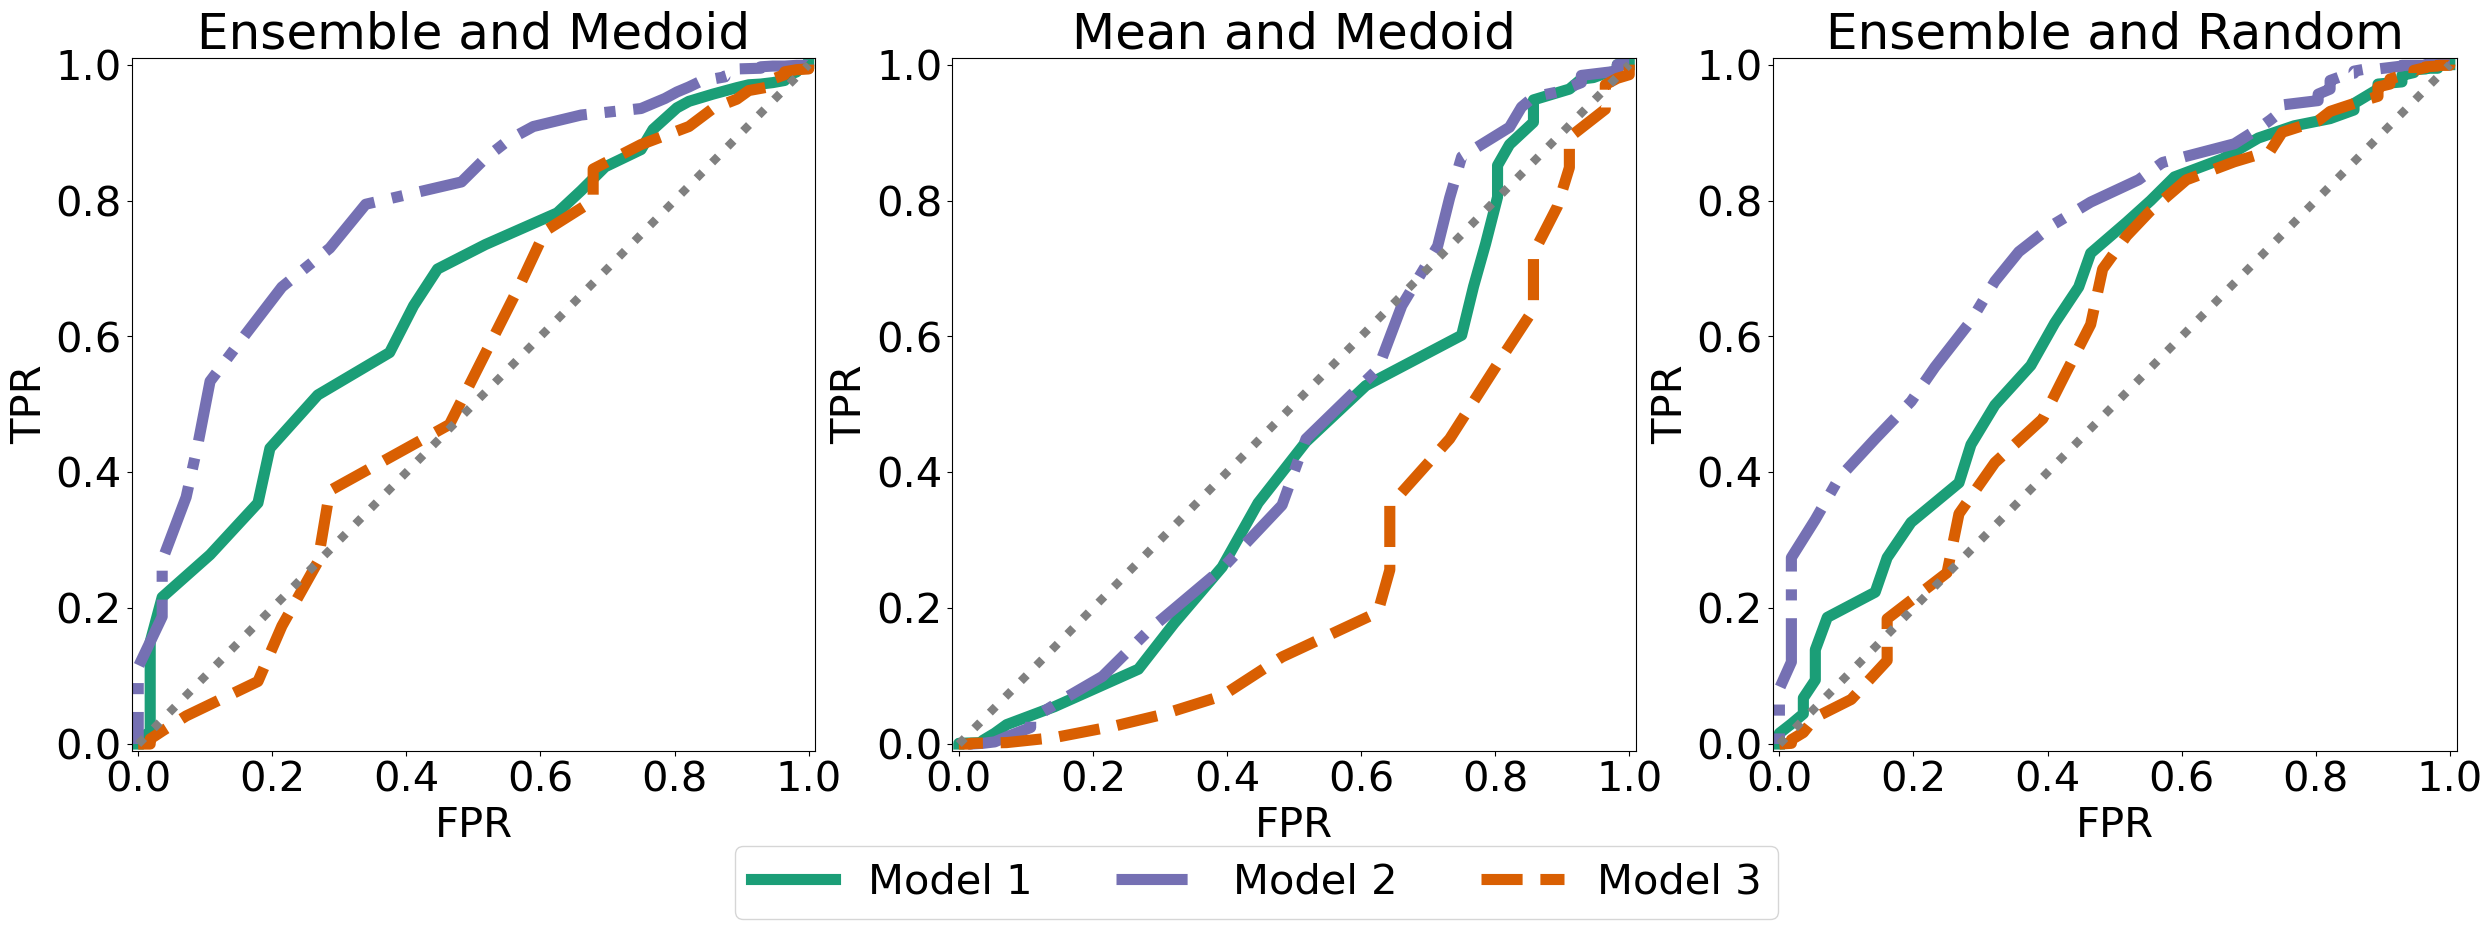

In [118]:
x_ = "FPR"
y_ = "TPR"

fig, ax = plt.subplots(1,3, figsize = (30,9))

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 30

linewidth = 8
lty = ["-", "-.", "--"]

model_colors = {"model1": "#1b9e77",  
                "model2": "#7570b3",
                "model3": "#d95f02"}


dataset_name = "bank"

for i, model_name in enumerate(model_colors.keys()):
    df1 = df_ens
    df2 = df_mean

    de = df1[df1["dataset"]==dataset_name][df1["model"]==model_name]
    dd = df2[df2["dataset"]==dataset_name][df2["model"]==model_name]

    print(de.shape)

    ax[0].plot(de[x_], de[y_], label= f"Model {i+1}", c = model_colors[model_name], linewidth = linewidth, linestyle = lty[i])
    ax[1].plot(dd[x_], dd[y_],  label= f"Model {i+1}", c = model_colors[model_name], linewidth = linewidth, linestyle = lty[i])
   

for i, model_name in enumerate(model_colors.keys()):
    df1 = df_ens_random

    de = df1[df1["dataset"]==dataset_name][df1["model"]==model_name]
    ax[2].plot(de[x_], de[y_], label= f"Model {i+1}", c = model_colors[model_name], linewidth = linewidth, linestyle = lty[i])
    
    
for col in range(3):
    ax[col].set_ylim(-0.01,1.01)
    ax[col].set_xlim(-0.01,1.01)
    ax[col].set_xlabel("FPR")
    ax[col].set_ylabel("TPR")
    ax[col].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax[col].plot(np.linspace(0,1), np.linspace(0,1), ":", c= "gray", linewidth = 6)

ax[0].set_title("Ensemble and Medoid")
ax[1].set_title("Mean and Medoid")
ax[2].set_title("Ensemble and Random")

fig.legend(["Model 1", "Model 2", "Model 3"], loc='lower center', ncol=3, bbox_to_anchor=(0.5,-0.1), bbox_transform=fig.transFigure)
plt.show()